<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#pT,-eta" data-toc-modified-id="pT,-eta-1">pT, eta</a></span></li><li><span><a href="#Neutral-energy-fraction" data-toc-modified-id="Neutral-energy-fraction-2">Neutral energy fraction</a></span></li><li><span><a href="#d0-of-tracks-inside-leptonJet-(max,-min)" data-toc-modified-id="d0-of-tracks-inside-leptonJet-(max,-min)-3">d0 of tracks inside leptonJet (max, min)</a></span></li><li><span><a href="#Isolation-(track-,-pfcand-)" data-toc-modified-id="Isolation-(track-,-pfcand-)-4">Isolation (track-, pfcand-)</a></span></li><li><span><a href="#ptDistribution,-dRSpread-(EtaPhiDistribution)" data-toc-modified-id="ptDistribution,-dRSpread-(EtaPhiDistribution)-5">ptDistribution, dRSpread (EtaPhiDistribution)</a></span></li><li><span><a href="#[jetsub]-$\lambda,-\epsilon$-|-pT,energy-distribution" data-toc-modified-id="[jetsub]-$\lambda,-\epsilon$-|-pT,energy-distribution-6">[jetsub] $\lambda, \epsilon$ | pT,energy distribution</a></span></li><li><span><a href="#[jetsub]-Energy-correlation-function-variables-{e1,-e2,-e3}" data-toc-modified-id="[jetsub]-Energy-correlation-function-variables-{e1,-e2,-e3}-7">[jetsub] Energy correlation function variables {e1, e2, e3}</a></span></li></ul></div>

Plot promising variables located previously from `DiscriminateVariables_sig.ipynb` on background samples.

Background sample categories including **QCD, diboson, DYJetsToLL, triboson, TTJets**

----
**variables summary**
1. pT
2. eta
3. neutral energy fraction
4. maxd0
5. mind0
6. tkIso
7. pfIso
8. pT distribution
9. etaPhi distribution
10. substructure momentum distribution
11. substructure energy distribution
12. ECF e1
13. ECF e2
14. ECF e3

In [1]:
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
from uproot_methods import TLorentzVectorArray
from histbook import *

import utils.uprootHelpers as uuh
import utils.commonHelpers as uch
import utils.histoHelpers as uhh

from utils.BackgroundDescription import BackgroundDescription
from utils.SignalDescription import SignalDescription

plt.style.use('default')
plt.rcParams.update(uhh.ffPltStyleSettings)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
bd = BackgroundDescription()
BkgStore = bd.getTotalFileWeights(groupby='tag', nth=-1)

In [3]:
BkgStore.keys()

dict_keys(['TTJets', 'DYJetsToLL', 'diboson', 'QCD', 'triboson'])

### pT, eta

In [4]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        self['jetp4'] = lambda: uuh.p4Array(t['pfjet_p4'])[self.mHLT]

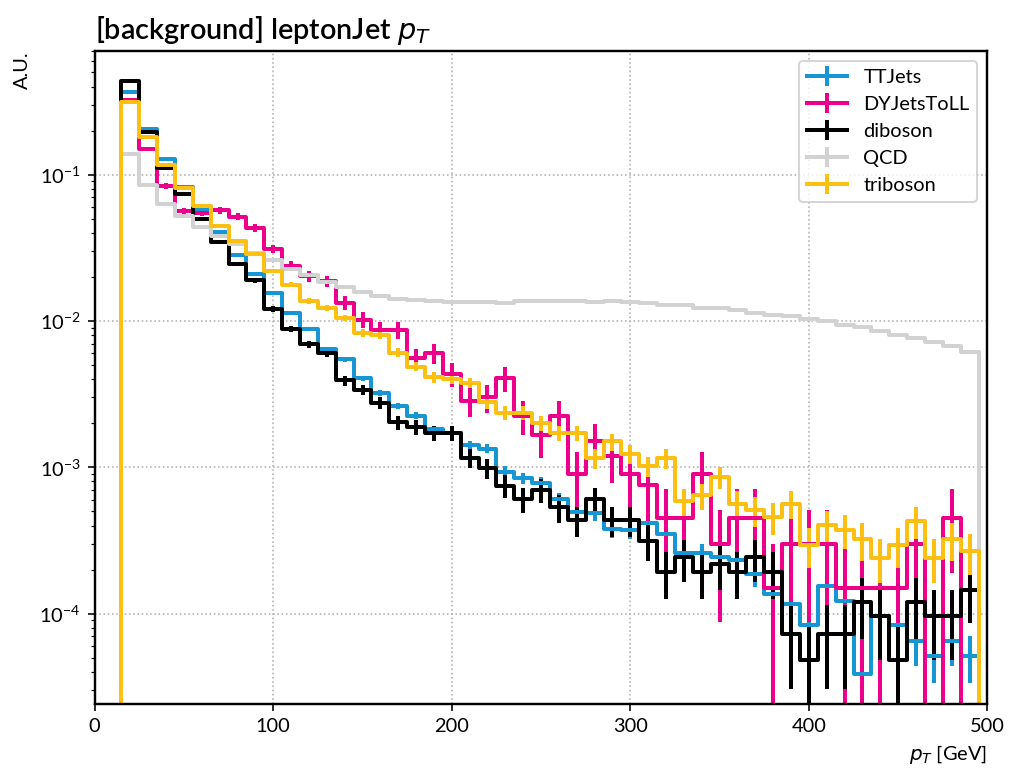

In [5]:
hs = dict()
fig, ax = plt.subplots(figsize=(8,6))
def doFill(d): return d.pt.flatten()

hPt = Hist(bin('x', 50, 0, 500))
for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hPt, loaded, 'jetp4', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='$p_T$ [GeV]',
    ylabel='A.U.',
    title='[background] leptonJet $p_T$'
)
fig.savefig('imgs/bkg-leptonjet-pt.pdf', bbox_inches='tight');

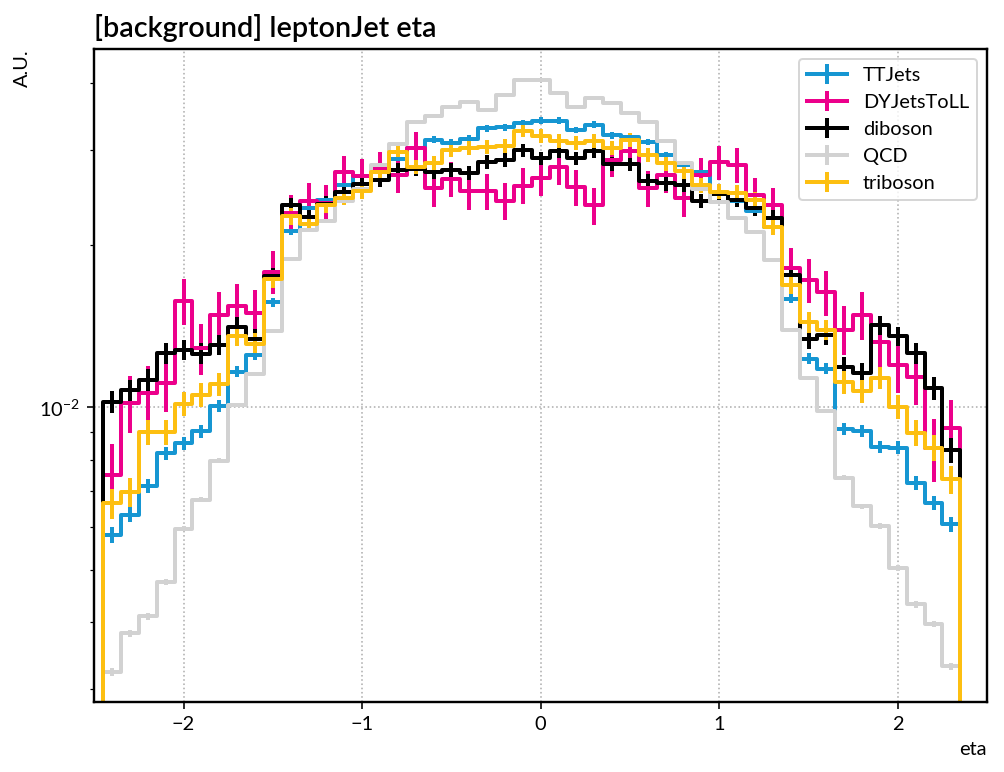

In [6]:
hs = dict()
fig, ax = plt.subplots(figsize=(8,6))
def doFill(d): return d.eta.flatten()

hEta = Hist(bin('x', 50, -2.5, 2.5))
for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hEta, loaded, 'jetp4', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='eta',
    ylabel='A.U.',
    title='[background] leptonJet eta'
)
fig.savefig('imgs/bkg-leptonjet-eta.pdf', bbox_inches='tight');

### Neutral energy fraction

In [7]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        jetp4 = uuh.p4Array(t['pfjet_p4'])
        neutralEnergyFrac = lambda: (
            t['pfjet_neutralEmE'].array()
            +t['pfjet_neutralHadronE'].array()
        )/jetp4.energy
        self['neufrac'] = lambda: neutralEnergyFrac()[self.mHLT]

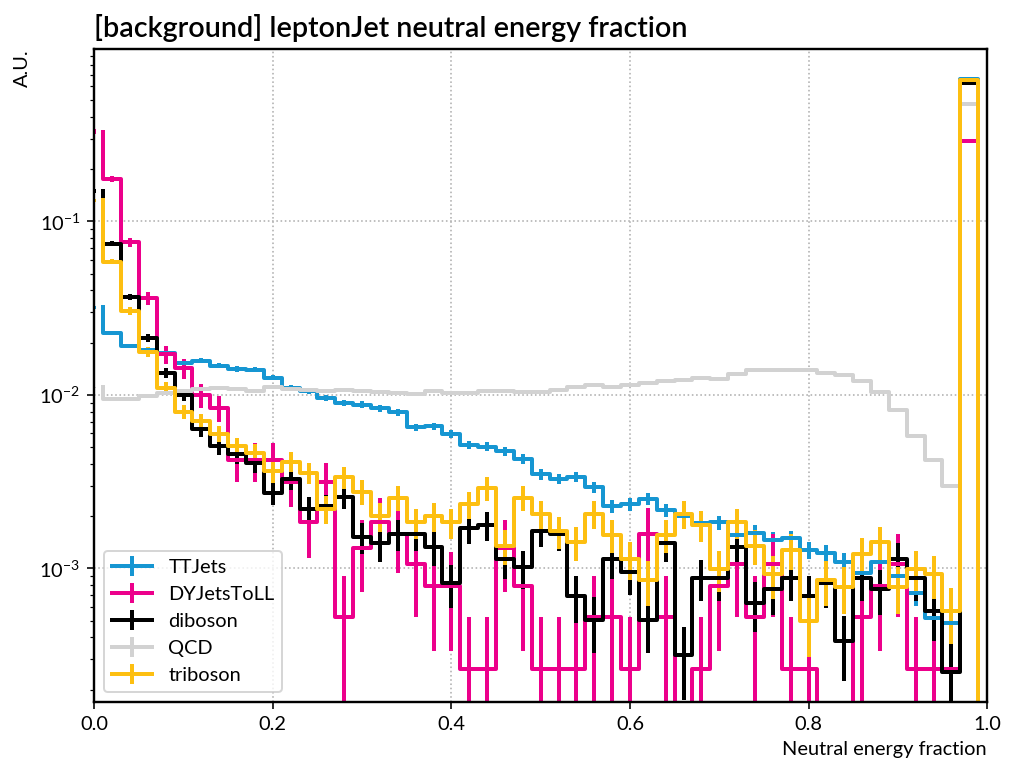

In [8]:
hs = dict()
fig, ax = plt.subplots(figsize=(8,6))
def doFill(d): return d.flatten()

hFrac = Hist(bin('x', 50, 0, 1))
for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hFrac, loaded, 'neufrac', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='Neutral energy fraction',
    ylabel='A.U.',
    title='[background] leptonJet neutral energy fraction'
)
fig.savefig('imgs/bkg-leptonjet-nef.pdf', bbox_inches='tight');

### d0 of tracks inside leptonJet (max, min)

In [9]:
def pickExtreme(ja, maxmin):
    if ja.size == 0:
        return np.array([])
    if maxmin == "max":
        return np.array([max(x) if x.size else np.nan for x in ja])
    if maxmin == "min":
        return np.array([min(x) if x.size else np.nan for x in ja])
    return np.array([])

class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        candTkd0 = lambda: uuh.NestNestObjArrayToJagged(t['pfjet_pfcand_tkD0'].array())
        self['maxd0'] = lambda: pickExtreme(candTkd0()[self.mHLT].flatten(), 'max')
        self['mind0'] = lambda: pickExtreme(candTkd0()[self.mHLT].flatten(), 'min')

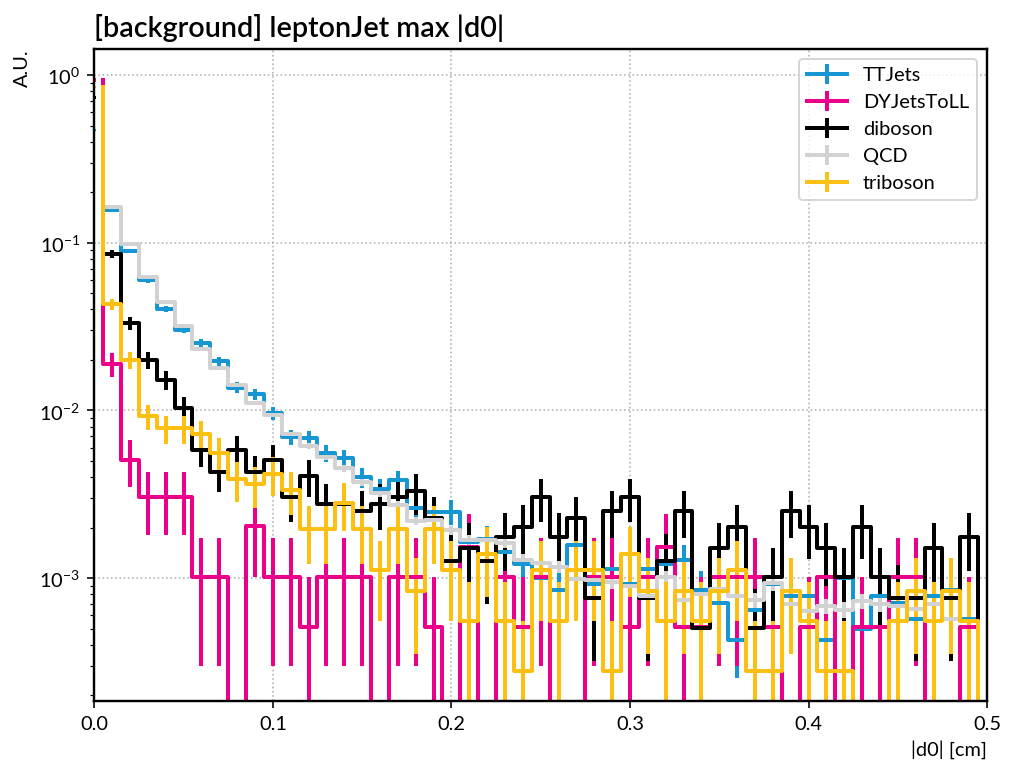

In [10]:
hs = dict()
def doFill(d): return d
fig, ax = plt.subplots(figsize=(8,6))
hD0 = Hist(bin('x', 50, 0, 0.5))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hD0, loaded, 'maxd0', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='|d0| [cm]',
    ylabel='A.U.',
    title='[background] leptonJet max |d0|'
)
fig.savefig('imgs/bkg-leptonjet-maxd0.pdf', bbox_inches='tight');

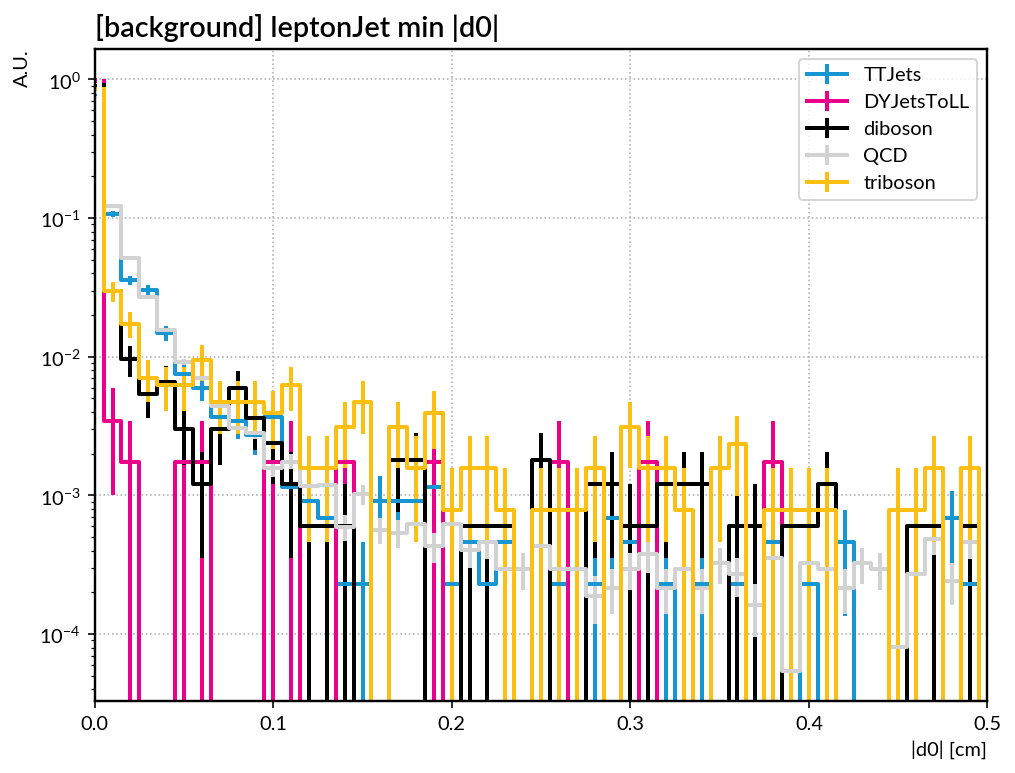

In [11]:
hs = dict()
def doFill(d): return d
fig, ax = plt.subplots(figsize=(8,6))
hD0 = Hist(bin('x', 50, 0, 0.5))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hD0, loaded, 'mind0', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='|d0| [cm]',
    ylabel='A.U.',
    title='[background] leptonJet min |d0|'
)
fig.savefig('imgs/bkg-leptonjet-mind0.pdf', bbox_inches='tight');

### Isolation (track-, pfcand-)

In [12]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        self['tkiso'] = lambda: self.tree['pfjet_tkIsolation05'].array()[self.mHLT]
        self['pfiso'] = lambda: self.tree['pfjet_pfIsolation05'].array()[self.mHLT]

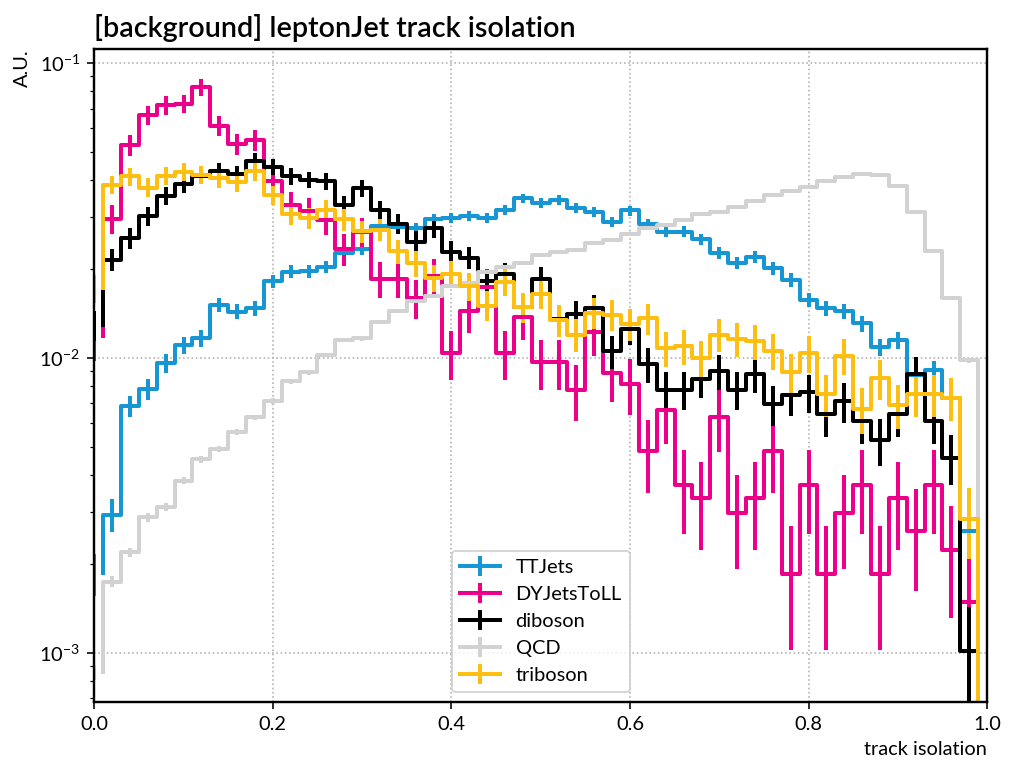

In [13]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hIso = Hist(bin('x', 50, 0, 1))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hIso, loaded, 'tkiso', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='track isolation',
    ylabel='A.U.',
    title='[background] leptonJet track isolation'
)
fig.savefig('imgs/bkg-leptonjet-tkiso.pdf', bbox_inches='tight');

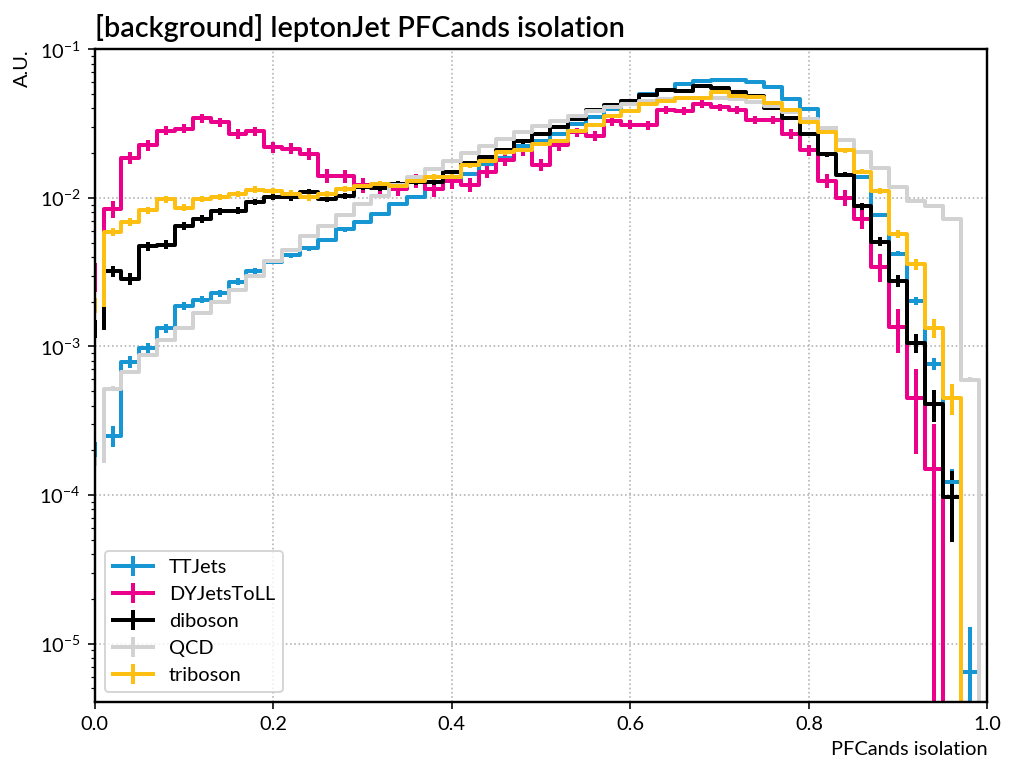

In [14]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hIso = Hist(bin('x', 50, 0, 1))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hIso, loaded, 'pfiso', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='PFCands isolation',
    ylabel='A.U.',
    title='[background] leptonJet PFCands isolation'
)
fig.savefig('imgs/bkg-leptonjet-pfiso.pdf', bbox_inches='tight');

### ptDistribution, dRSpread (EtaPhiDistribution)

In [15]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        self['ptspread'] = lambda: t['pfjet_ptDistribution'].array()[self.mHLT]
        self['drspread'] = lambda: t['pfjet_dRSpread'].array()[self.mHLT]

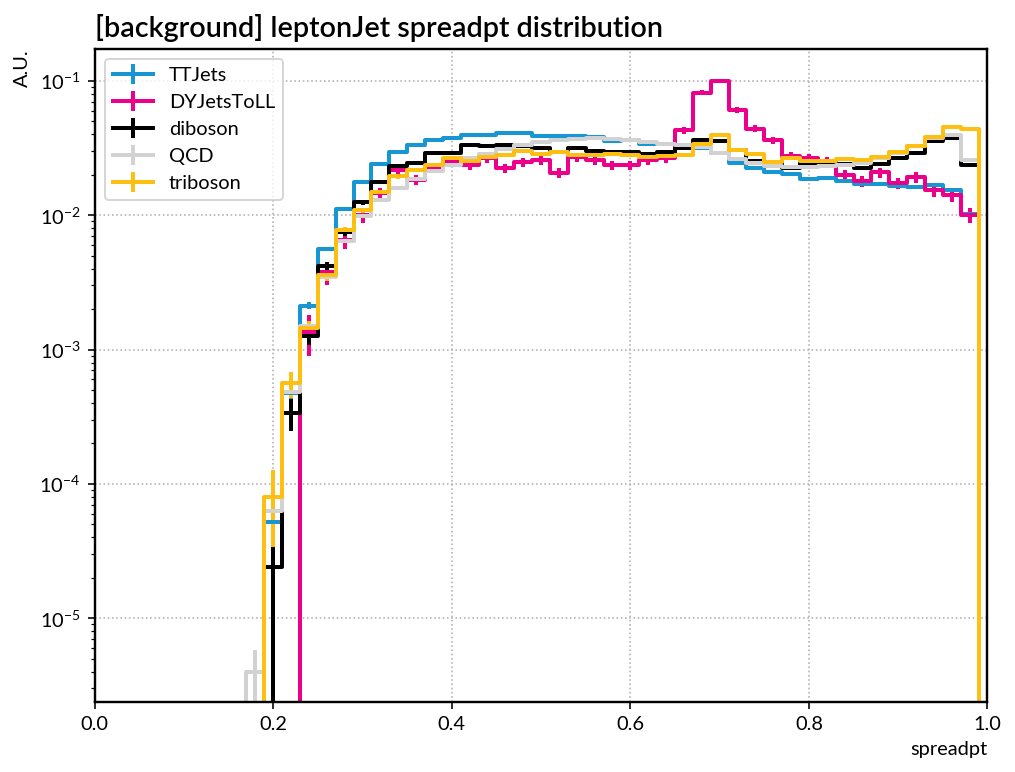

In [16]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hPtd = Hist(bin('x', 50, 0, 1))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hPtd, loaded, 'ptspread', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )
    
uhh.OverlayHisto(
    hs, ax,
    xlabel='spreadpt',
    ylabel='A.U.',
    title='[background] leptonJet spreadpt distribution'
)
fig.savefig('imgs/bkg-leptonjet-spreadpt.pdf', bbox_inches='tight');

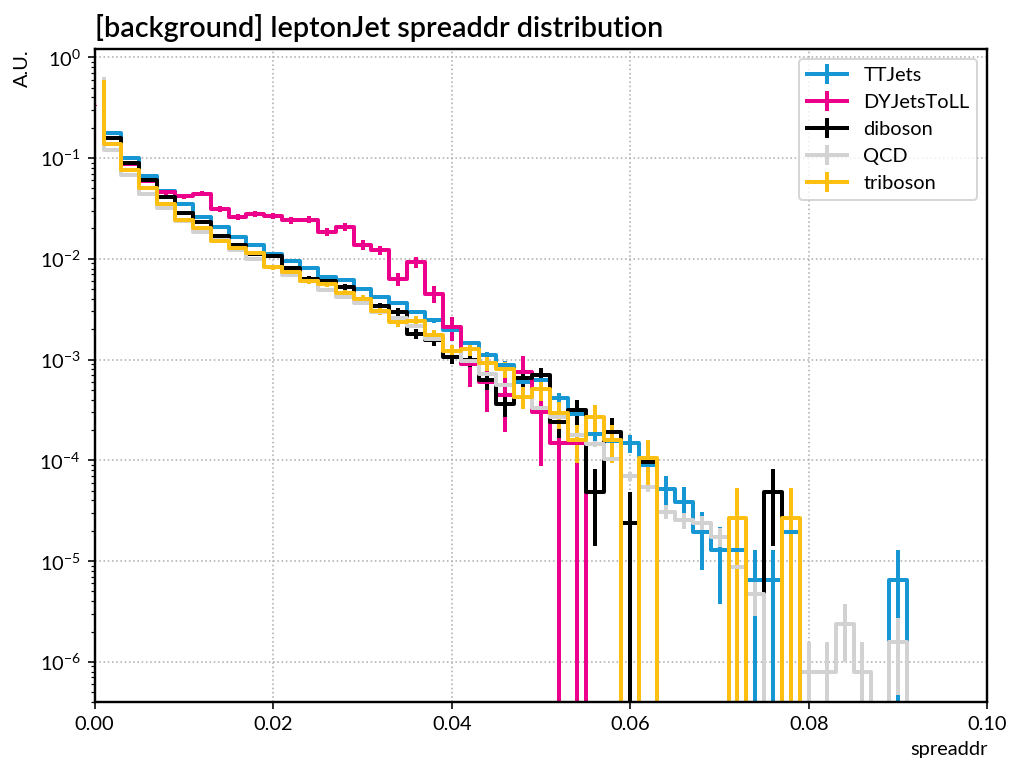

In [17]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hPtd = Hist(bin('x', 50, 0, 0.1))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hPtd, loaded, 'drspread', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )
    
uhh.OverlayHisto(
    hs, ax,
    xlabel='spreaddr',
    ylabel='A.U.',
    title='[background] leptonJet spreaddr distribution'
)
fig.savefig('imgs/bkg-leptonjet-spreaddr.pdf', bbox_inches='tight');

### [jetsub] $\lambda, \epsilon$ | pT,energy distribution

In [18]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        self['lambda'] = lambda: t['pfjet_subjet_lambda'].array()[self.mHLT]
        self['epsilon'] = lambda: t['pfjet_subjet_epsilon'].array()[self.mHLT]

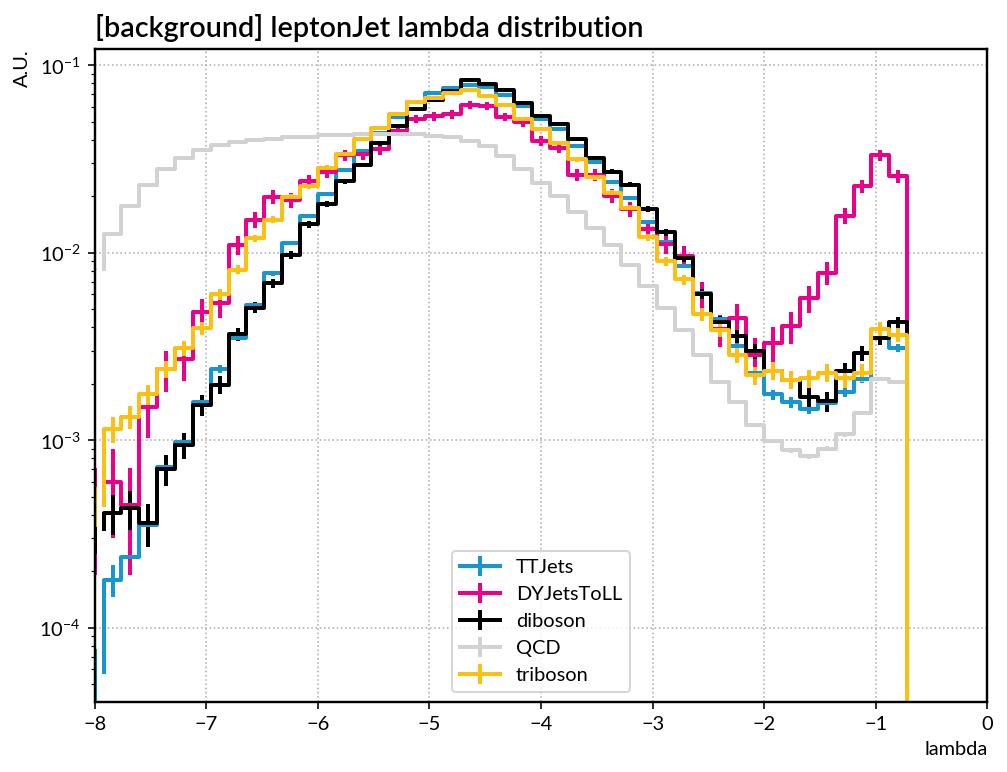

In [19]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, -8, 0))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hDist, loaded, 'lambda', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='lambda',
    ylabel='A.U.',
    title='[background] leptonJet lambda distribution'
)
fig.savefig('imgs/bkg-leptonjet-lambda.pdf', bbox_inches='tight');

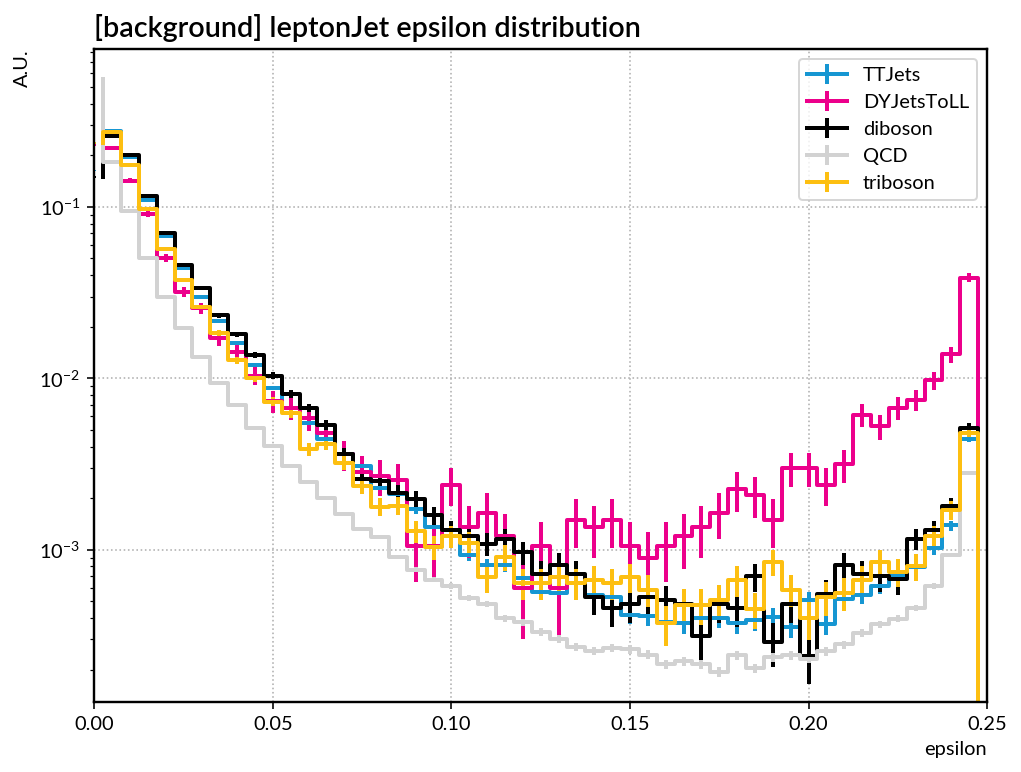

In [20]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 0.25))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hDist, loaded, 'epsilon', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )

uhh.OverlayHisto(
    hs, ax,
    xlabel='epsilon',
    ylabel='A.U.',
    title='[background] leptonJet epsilon distribution'
)
fig.savefig('imgs/bkg-leptonjet-epsilon.pdf', bbox_inches='tight');

### [jetsub] Energy correlation function variables {e1, e2, e3}

In [21]:
class loaded(uhh.ffLoader):
    def __init__(self, filename):
        super().__init__(filename)
        t = self.tree
        self['e1'] = lambda: t['pfjet_subjet_ecf1'].array()[self.mHLT]
        self['e2'] = lambda: t['pfjet_subjet_ecf2'].array()[self.mHLT]
        self['e3'] = lambda: t['pfjet_subjet_ecf3'].array()[self.mHLT]

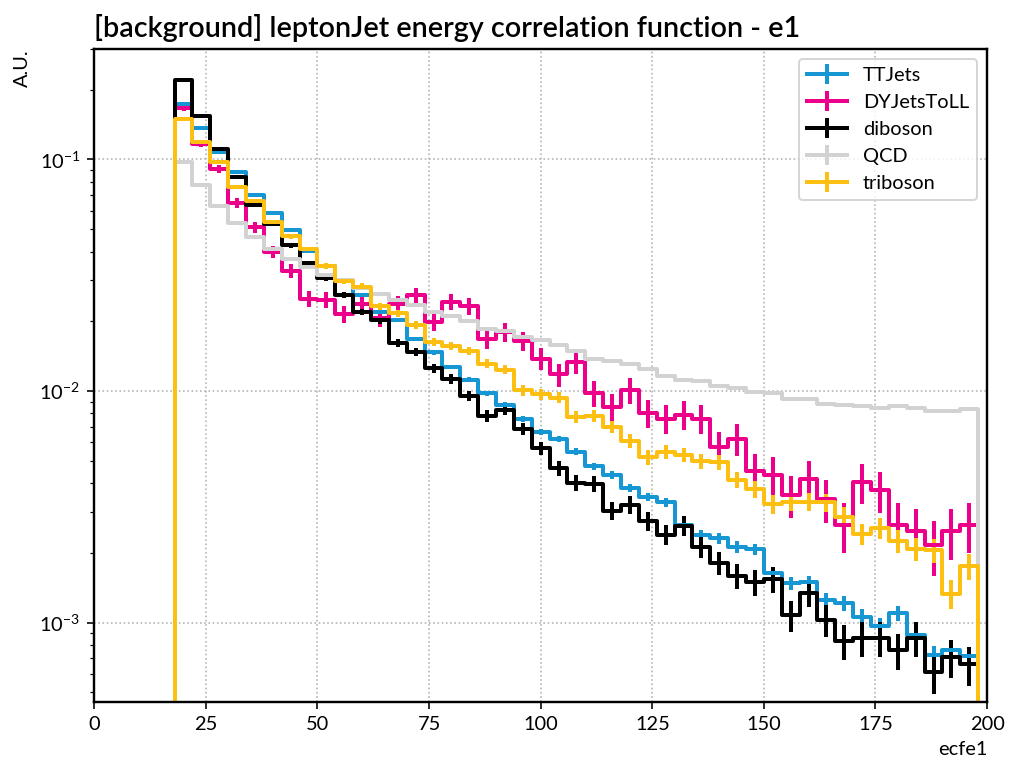

In [22]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 200))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hDist, loaded, 'e1', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )
    
uhh.OverlayHisto(
    hs, ax,
    xlabel='ecfe1',
    ylabel='A.U.',
    title='[background] leptonJet energy correlation function - e1'
)
fig.savefig('imgs/bkg-leptonjet-ecfe1.pdf', bbox_inches='tight');

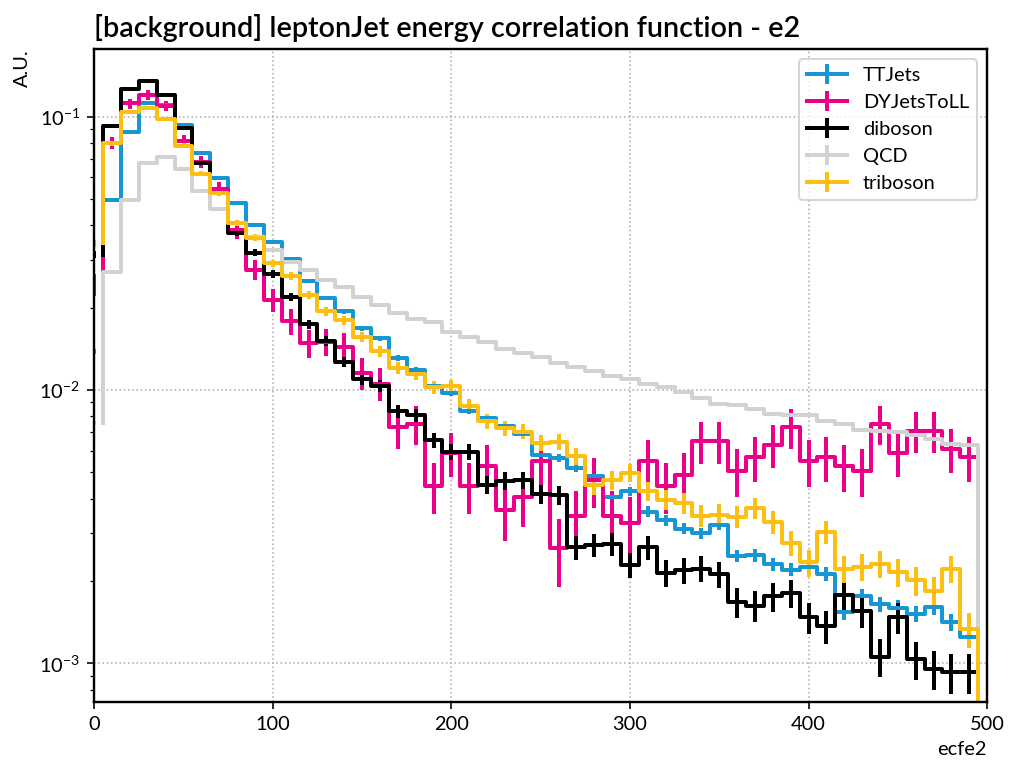

In [23]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 500))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hDist, loaded, 'e2', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )
    
uhh.OverlayHisto(
    hs, ax,
    xlabel='ecfe2',
    ylabel='A.U.',
    title='[background] leptonJet energy correlation function - e2'
)
fig.savefig('imgs/bkg-leptonjet-ecfe2.pdf', bbox_inches='tight');

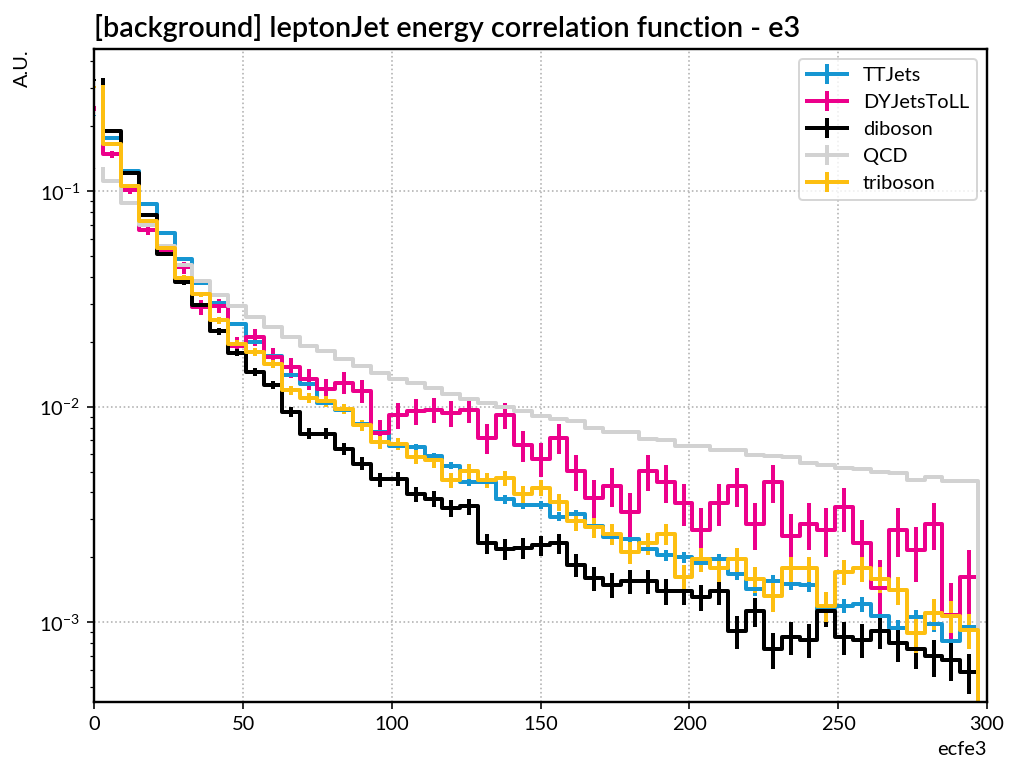

In [24]:
hs = dict()
def doFill(d): return d.flatten()
fig, ax = plt.subplots(figsize=(8,6))
hDist = Hist(bin('x', 50, 0, 300))

for k in BkgStore.keys():
    hs[k] = reduce(
        lambda a, b: a+b,
        [
            uhh.MultiFill(hDist, loaded, 'e3', doFill, filelist, weight=w) 
            for filelist, w in BkgStore[k]
        ]
    )
    
uhh.OverlayHisto(
    hs, ax,
    xlabel='ecfe3',
    ylabel='A.U.',
    title='[background] leptonJet energy correlation function - e3'
)
fig.savefig('imgs/bkg-leptonjet-ecfe3.pdf', bbox_inches='tight');

----